In [65]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_docs').getOrCreate()
from pyspark.sql.functions import col, sum,  mean, stddev, regexp_replace
# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)

In [64]:
msd = spark.read.csv('Project Data/benefit_type_data_merged.csv',inferSchema=True,header=True) 

column_names = msd.columns[:42]
msd = msd.select([col(column) for column in column_names])
msd.show(5)

+------+-----------------+-------+---------+---------+--------+--------+--------+-----------+--------+----------+--------+----------------------------------------+------------------+-------------------+--------+----------+---------+---------+---------+---------+------------+---------+-----------+---------+-----------------------------------------+-------------------+------------------------+--------+----------+---------+---------+---------+---------+------------+---------+-----------+---------+-----------------------------------------+-------------------+-------------------+-----------------------+
|  Date|Jobseeker Support|JS Male|JS Female| JS 18-24|JS 25-39|JS 40-54|JS 55-64|JS European|JS Maori|JS Pacific|JS Asian|JS Middle Eastern/Latin American/African|JS Other ethnicity|Sole Parent Support|SPS Male|SPS Female|SPS 18-24|SPS 25-39|SPS 40-54|SPS 55-64|SPS European|SPS Maori|SPS Pacific|SPS Asian|SPS Middle Eastern/Latin American/African|SPS Other ethnicity|Supported Living Payment|

In [66]:
# The show method allows you visualise DataFrames. We can see that there are two columns.
# 定义要转换的列名
columns_to_convert = msd.columns[1:]  # 除第一列外的所有列

# 去掉数值中的逗号并转换为数值类型
for column in columns_to_convert:
    msd = msd.withColumn(column, regexp_replace(col(column), ',', '').cast('float'))

# 检查转换后的数据类型
msd.printSchema()


root
 |-- Date: string (nullable = true)
 |-- Jobseeker Support: float (nullable = true)
 |-- JS Male: float (nullable = true)
 |-- JS Female: float (nullable = true)
 |-- JS 18-24: float (nullable = true)
 |-- JS 25-39: float (nullable = true)
 |-- JS 40-54: float (nullable = true)
 |-- JS 55-64: float (nullable = true)
 |-- JS European: float (nullable = true)
 |-- JS Maori: float (nullable = true)
 |-- JS Pacific: float (nullable = true)
 |-- JS Asian: float (nullable = true)
 |-- JS Middle Eastern/Latin American/African: float (nullable = true)
 |-- JS Other ethnicity: float (nullable = true)
 |-- Sole Parent Support: float (nullable = true)
 |-- SPS Male: float (nullable = true)
 |-- SPS Female: float (nullable = true)
 |-- SPS 18-24: float (nullable = true)
 |-- SPS 25-39: float (nullable = true)
 |-- SPS 40-54: float (nullable = true)
 |-- SPS 55-64: float (nullable = true)
 |-- SPS European: float (nullable = true)
 |-- SPS Maori: float (nullable = true)
 |-- SPS Pacific: float

+-------+------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+----------------------------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------+------------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------+-------------------+-------------------+-----------------------+
|summary|  Date|Jobseeker Support|           JS Male|        JS Female|          JS 18-24|         JS 25-39|         JS 40-54|      

In [67]:
msd.describe().show()

+-------+------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+----------------------------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------+------------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------+-------------------+-------------------+-----------------------+
|summary|  Date|Jobseeker Support|           JS Male|        JS Female|          JS 18-24|         JS 25-39|         JS 40-54|      

In [68]:
null_counts_dict = msd.select([sum(col(c).isNull().cast("int")).alias(c) for c in msd.columns]).collect()[0].asDict()

null_columns = {k: v for k, v in null_counts_dict.items() if v > 0}

for col_name, null_count in null_columns.items():
    print(f"Column '{col_name}' has {null_count} null values")

Column 'JS Female' has 2 null values
Column 'JS 25-39' has 1 null values
Column 'JS Pacific' has 1 null values
Column 'JS Asian' has 1 null values
Column 'SPS 18-24' has 1 null values


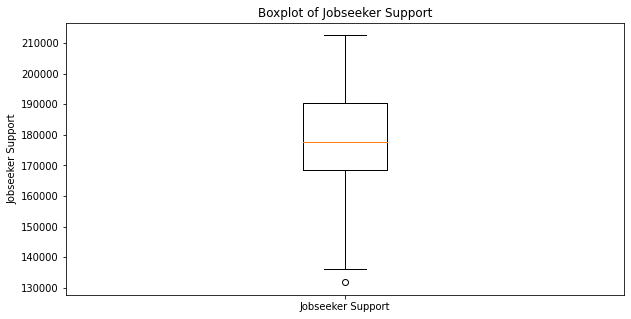

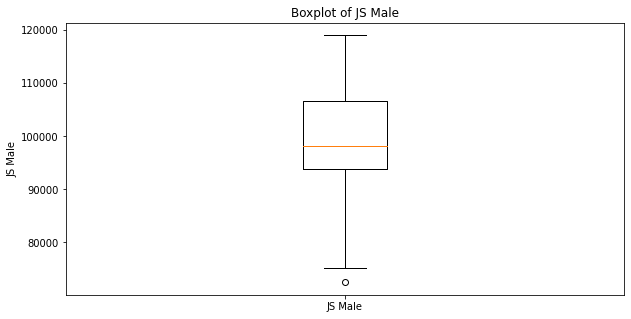

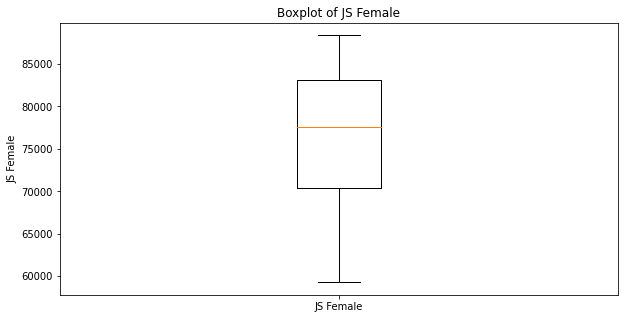

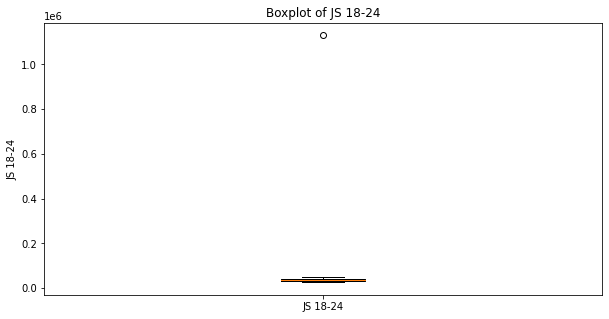

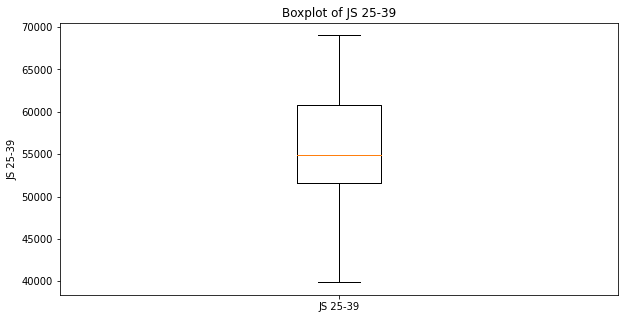

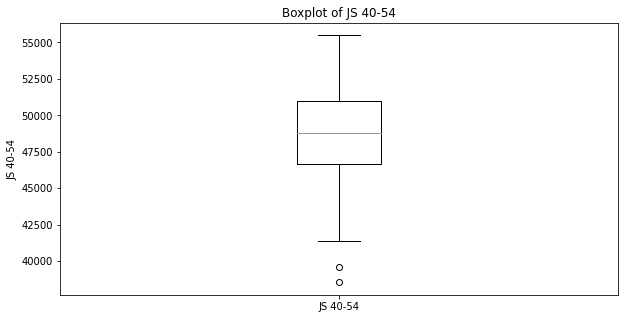

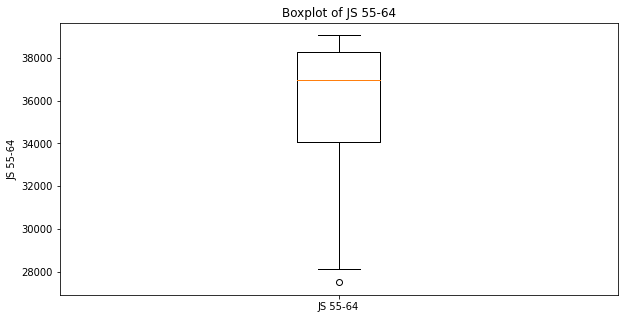

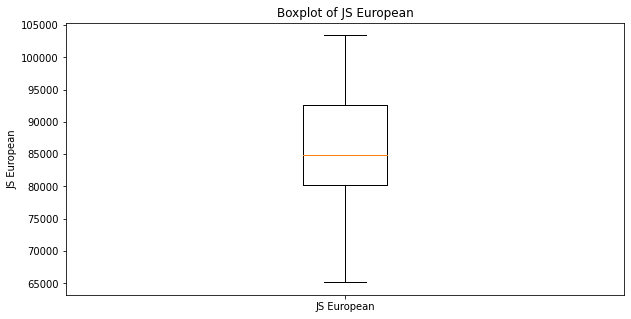

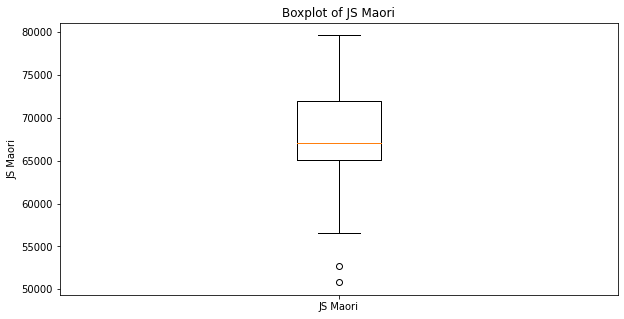

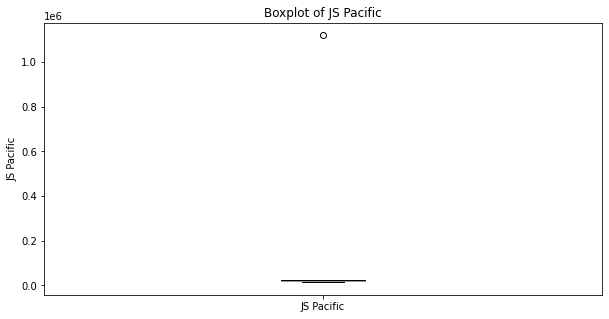

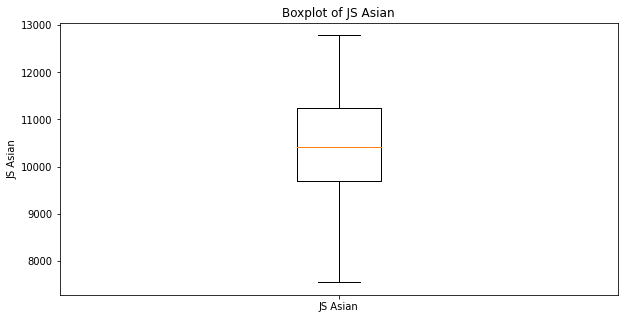

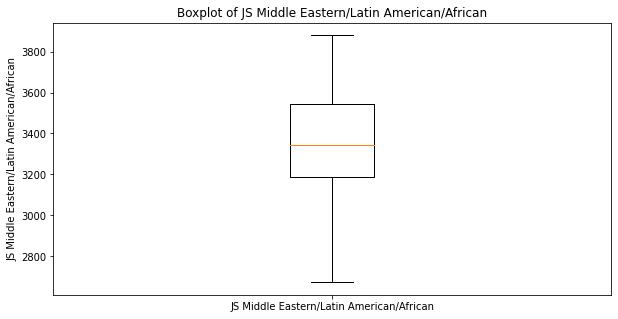

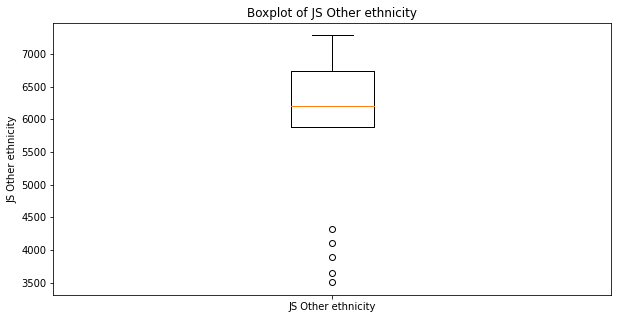

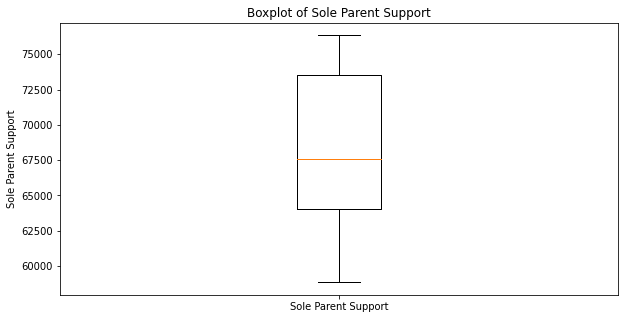

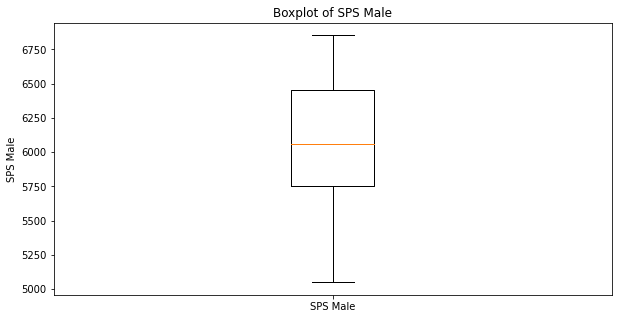

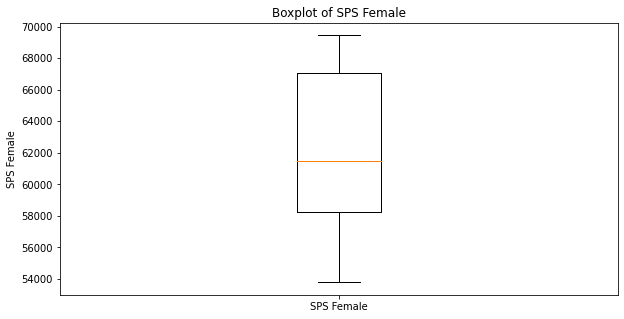

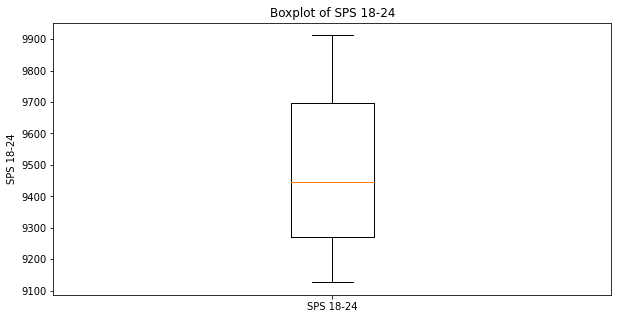

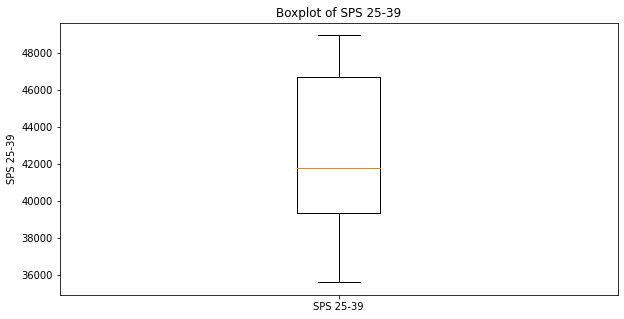

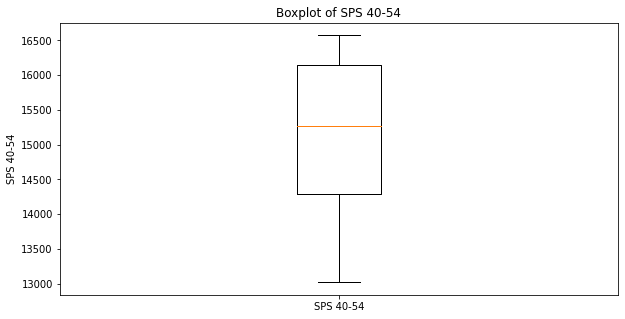

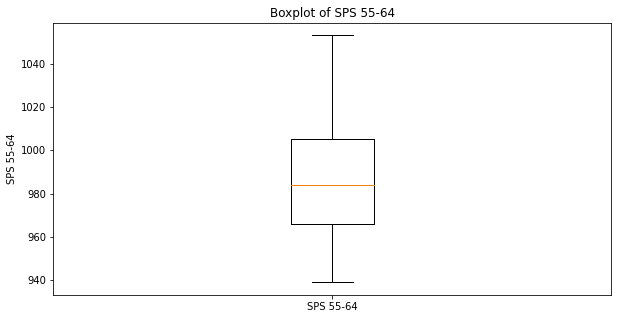

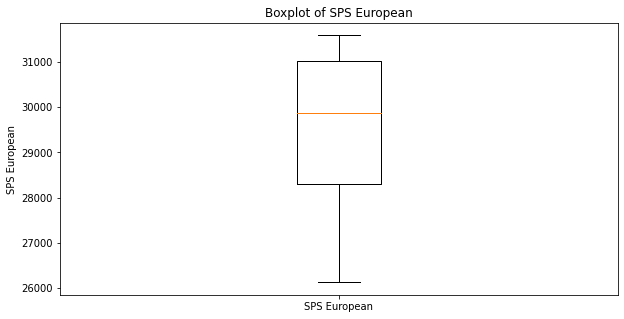

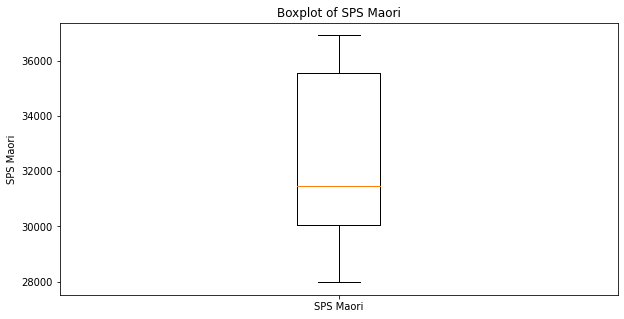

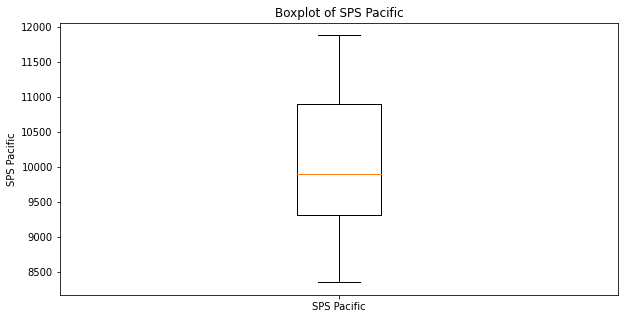

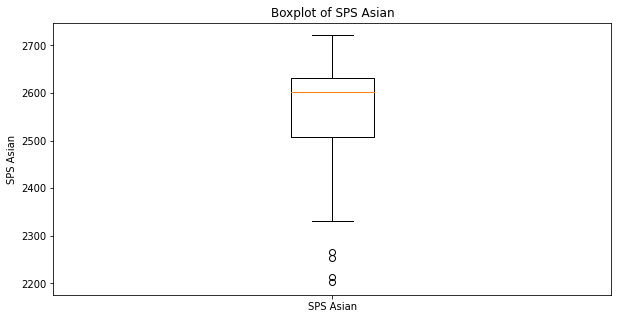

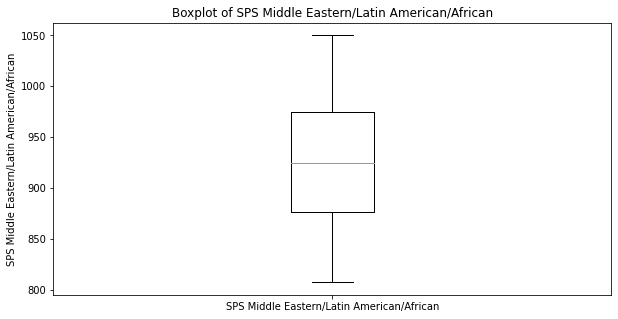

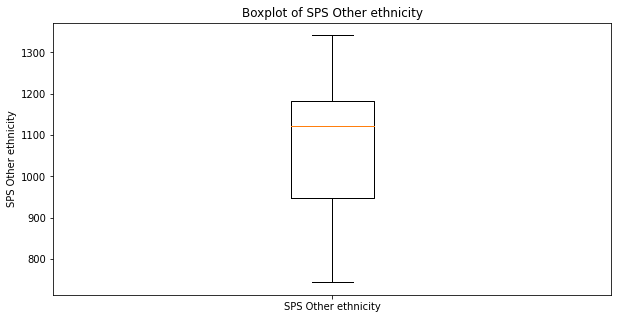

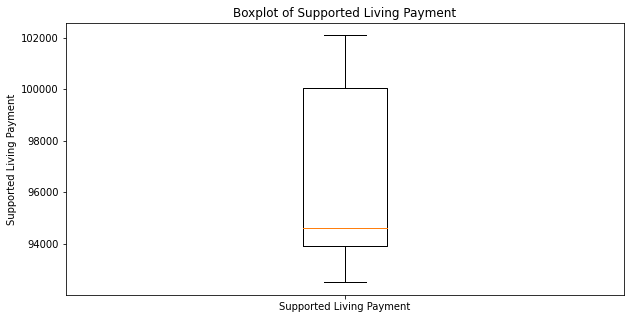

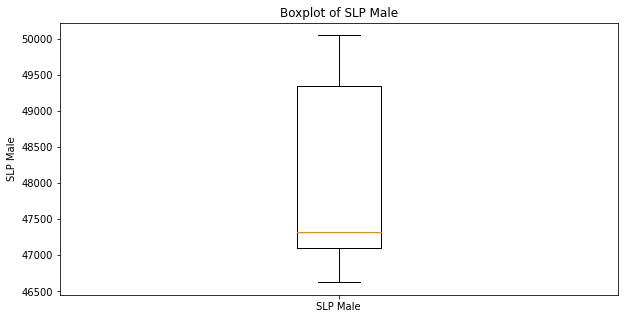

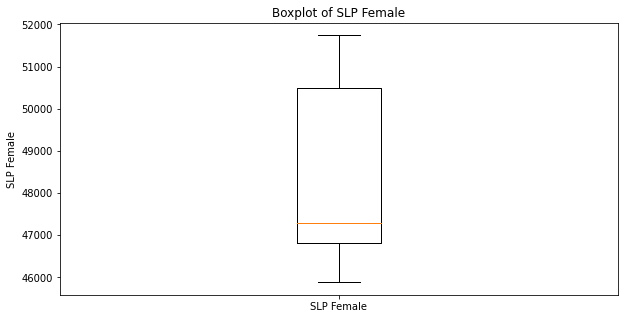

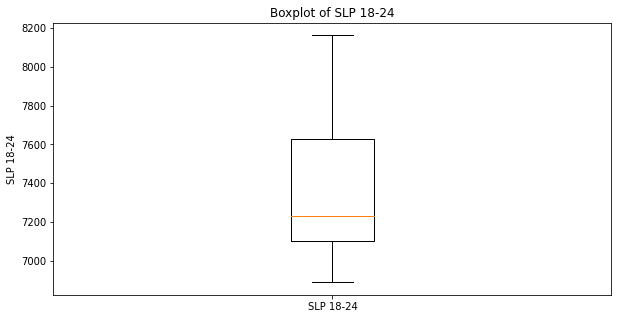

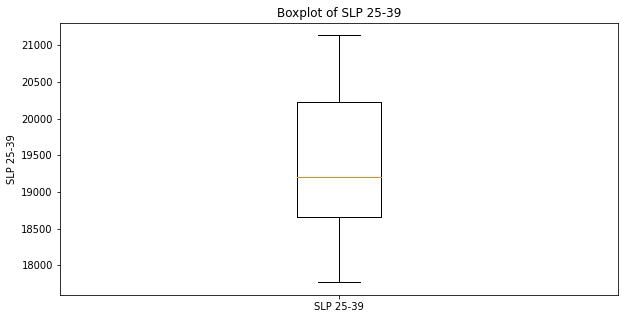

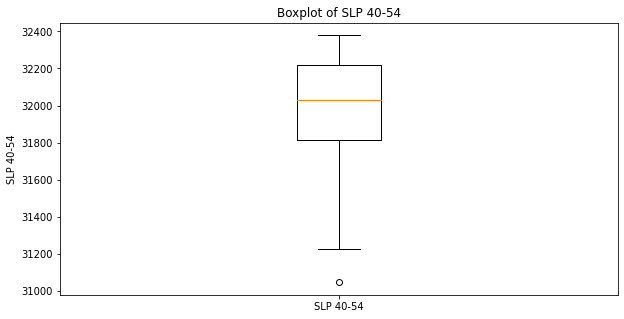

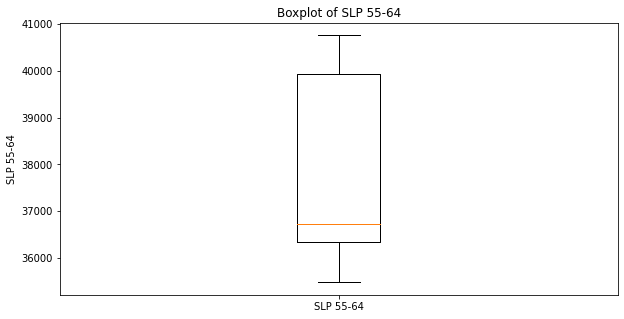

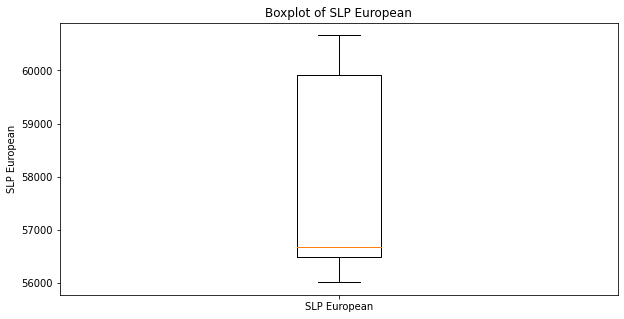

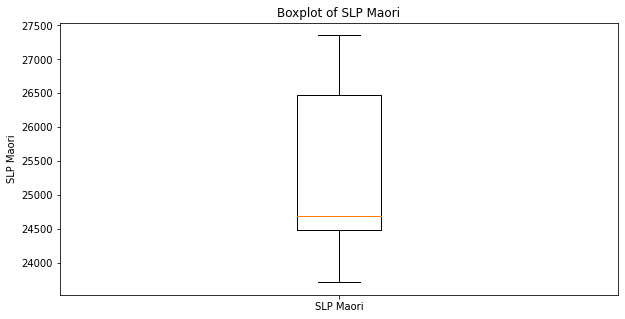

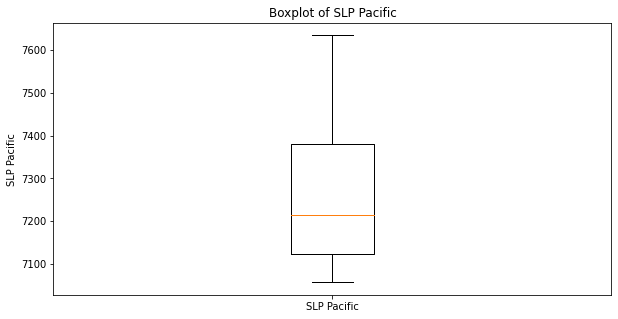

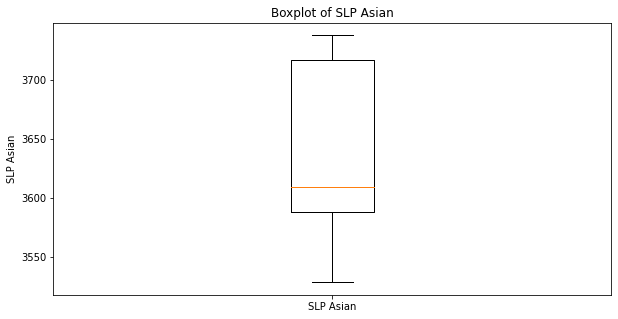

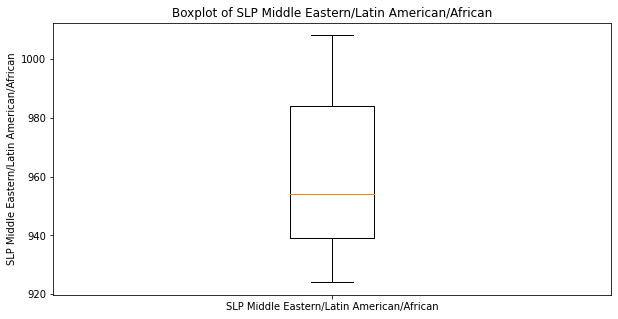

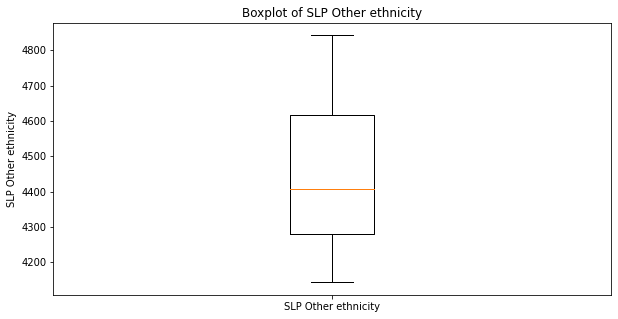

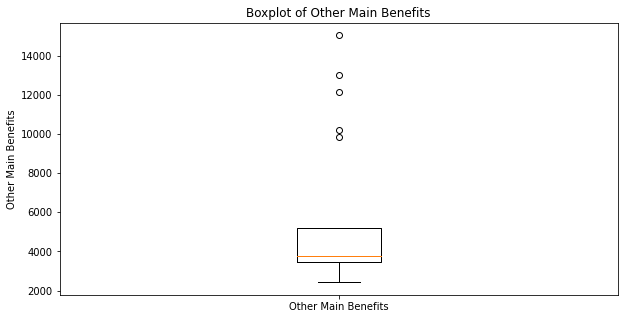

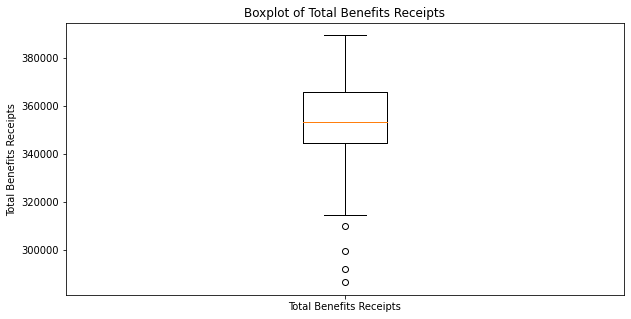

In [71]:

# 为每列绘制箱线图
for column in columns_to_convert:
    # 将每列的数据转换为数值类型并收集到一个本地列表
    data = msd.select(col(column).cast('int')).rdd.flatMap(lambda x: x).collect()
    
    # 过滤掉None值
    data = [x for x in data if x is not None]
    
    
    # 绘制箱线图
    plt.figure(figsize=(10, 5))
    plt.boxplot(data)
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.xticks([1], [column])  # 仅一个箱线图，所以只需要一个x轴标签
    plt.show()

In [72]:
for column in columns_to_convert:
    column_dtype = dict(msd.dtypes)[column]
    if column_dtype in ['int', 'double', 'float']:
        median_value = msd.approxQuantile(column, [0.5], 0.01)[0]
        msd = msd.fillna(median_value, subset=[column])

In [75]:
null_counts_dict = msd.select([sum(col(c).isNull().cast("int")).alias(c) for c in msd.columns]).collect()[0].asDict()

null_columns = {k: v for k, v in null_counts_dict.items() if v > 0}

if null_columns:
    for col_name, null_count in null_columns.items():
        print(f"Column '{col_name}' has {null_count} null values")
else:
    print("No columns have null values")

No columns have null values


In [ ]:




def replace_outliers_with_median(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return col.apply(lambda x: x if (x >= lower_bound and x <= upper_bound) else col.median())

for col in msd.columns:
    if pd.api.types.is_numeric_dtype(msd[col]):
        msd[col] = replace_outliers_with_median(msd[col])

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    msd[col].plot(kind='box')
    plt.title(f'Box Plot of {col}')
    plt.show()

# Add new features
msd['JS_lowAge'] = msd['JS 18-24'] + msd['JS 25-39']
msd['JS_highAge'] = msd['JS 40-54'] + msd['JS 55-64']
msd['SPS_lowAge'] = msd['SPS 18-24'] + msd['SPS 25-39']
msd['SPS_highAge'] = msd['SPS 40-54'] + msd['SPS 55-64']
msd['SLP_lowAge'] = msd['SLP 18-24'] + msd['SLP 25-39']
msd['SLP_highAge'] = msd['SLP 40-54'] + msd['SLP 55-64']

# Data reduction
cols_to_drop = ['JS 18-24', 'JS 25-39', 'JS 40-54','JS 55-64', 'SPS 18-24', 'SPS 25-39', 'SPS 40-54', 'SPS 55-64', 'SLP 18-24', 'SLP 25-39', 'SLP 40-54','SLP 55-64',
                'JS Middle Eastern/Latin American/African', 'JS Other ethnicity','SPS Middle Eastern/Latin American/African', 'SPS Other ethnicity','SLP Middle Eastern/Latin American/African', 'SLP Other ethnicity',
                'Other Main Benefits']

msd.drop(columns=cols_to_drop, inplace=True)

print(msd.columns)

numeric_columns = msd.select_dtypes(include=['number']).columns

# Apply logarithmic transformation and generate hist chart
for col in numeric_columns:
    msd[col] = msd[col].apply(lambda x: np.log(x) if x > 0 else np.nan)
    data_to_plot = msd[col].dropna()
    mu, sigma = data_to_plot.mean(), data_to_plot.std()
    kde = gaussian_kde(data_to_plot)
    x = np.linspace(data_to_plot.min(), data_to_plot.max(), 100)
    y = kde.evaluate(x)
    
    plt.figure(figsize=(6, 4))
    plt.hist(data_to_plot, bins=7, alpha=0.6, density=True, color='blue')
    plt.plot(x, y, 'r-', label=f'KDE Curve (μ={mu:.2f}, σ={sigma:.2f})')
    plt.title(f'Log-Transformed Histogram of {col}')
    plt.xlabel('Log-Transformed Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# Build model, split the dataset, compare the factors and generate scarrter chart and bar chart for analyse
msdModel = LinearRegression()

X = msd[['Jobseeker Support', 'Sole Parent Support', 'Supported Living Payment']]  
y = msd['Total Benefits Receipts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

msdTotal = LinearRegression()
msdTotal.fit(X_train, y_train)

y_pred = msdTotal.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')
print(f'Accuracy: {100 * r2:.2f}%')

plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

coefficients = msdTotal.coef_
featureTotal = ['Jobseeker Support', 'Sole Parent Support', 'Supported Living Payment']
coefficients_with_names = list(zip(featureTotal, coefficients))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)


print("Sorted coefficients:")
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

plt.figure(figsize=(8, 6))
plt.bar(featureTotal, coefficients, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Importance')
plt.show()


X1 = msd[['JS_lowAge', 'JS_highAge']]  
y1 = msd['Jobseeker Support']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

msdJSAge = LinearRegression()
msdJSAge.fit(X_train1, y_train1)

y_pred1 = msdJSAge.predict(X_test1)

mse1 = mean_squared_error(y_test1, y_pred1)
r21 = r2_score(y_test1, y_pred1)

print(f'Mean Squared Error: {mse1:.6f}')
print(f'R-squared: {r21:.6f}')
print(f'Accuracy: {100 * r21:.2f}%')

plt.scatter(y_test, y_pred1, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

coefficients = msdJSAge.coef_
featureAge = ['JS_lowAge', 'JS_highAge']
coefficients_with_names = list(zip(featureAge, coefficients))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Sorted coefficients:")
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

X2 = msd[['SPS_lowAge', 'SPS_highAge']]  
y2 = msd['Sole Parent Support']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.35, random_state=42)
msdSPSAge = LinearRegression()
msdSPSAge.fit(X_train2, y_train2)

y_pred2 = msdSPSAge.predict(X_test2)

mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)

print(f'Mean Squared Error: {mse2:.8f}')
print(f'R-squared: {r22:.8f}')
print(f'Accuracy: {100 * r22:.8f}%')

plt.scatter(y_test2, y_pred2, color='blue')
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

coefficients = msdSPSAge.coef_
featureAge1 = ['SPS_lowAge', 'SPS_highAge']
coefficients_with_names = list(zip(featureAge1, coefficients))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Sorted coefficients:")
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

plt.figure(figsize=(8, 6))
plt.bar(featureAge1, coefficients, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Importance')
plt.show()

X3 = msd[['JS European', 'JS Maori','JS Pacific','JS Asian']]  
y3 = msd['Jobseeker Support']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.35, random_state=42)
msdJSEth = LinearRegression()
msdJSEth.fit(X_train3, y_train3)

y_pred3 = msdJSEth.predict(X_test3)

mse3 = mean_squared_error(y_test3, y_pred3)
r23 = r2_score(y_test3, y_pred3)

print(f'Mean Squared Error: {mse3:.8f}')
print(f'R-squared: {r23:.8f}')
print(f'Accuracy: {100 * r23:.8f}%')

plt.scatter(y_test3, y_pred3, color='blue')
plt.plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], 'k--', lw=2)  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

coefficients = msdJSEth.coef_
featureEth = ['JS European', 'JS Maori','JS Pacific','JS Asian']
coefficients_with_names = list(zip(featureEth, coefficients))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Sorted coefficients:")
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

plt.figure(figsize=(8, 6))
plt.bar(featureEth, coefficients, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Importance')
plt.show()